In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer,MissingIndicator, SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from autorank import autorank,create_report, plot_stats
warnings.filterwarnings('ignore')

random_state = 567697779
np.random.seed(random_state)

Task 1 Imputation
======

Load the dataset using read_csv and convert to numpy form.  
First we check the balanced of the y labels, we can see it has an even distribution of 500-500. This tells us we dont need to use stratified-kfold CV.  
We can also have a look at the shape of the data we are working with.

After a quick look at the data from excel, I can see that there is a missing cell on every row in a diagonal pattern.  
From here, we must determine what is the best way to impute the missing data. Dropping the rows would not be an option as there is missing data on every row.  
Here you see me using 5 different imputation methods (mean,median,most frequent, iterative(most probable) and k-NN).  
I create a dataframe for each of the 5 methods for comparisons later.  My guess at this stage would be iterative or mean imputation being the most effective.  

In the third cell I am running a basic random forest classifier on each of the imputed datasets to get a rough idea of what imputation methods work the best.  
I am splitting each dataset and fitting the model on just the training set. Then I am performing 10 repeats of 10-fold CV to get an idea of how good the model is performing.  
From the outputs below we can see that the iterative imputer tied with mean imputation. I will be using the iteratively imputated dataset from task 2 onwards.  
I believe the iteratively imputated dataset will be more robust as it has gone through 12 iterations of missing value preduction via bayesian-ridge regression. If the mean and iterative results are almost identical, I would prefer the iterative method that generated the value over 12 iterations instead of simply taking the mean of the column, which can be prone to outliers.



In [2]:
data = pd.read_csv('data_A2.csv', sep = ',', header = None, na_values ='?',)
labels = pd.read_csv('labels_A2.csv', sep=',', header = None, na_values = '?', dtype='int32')

X = data.to_numpy()
y = labels.to_numpy().ravel()

# check y balance
y_count = labels.groupby(0).size()

print(y_count)

print(X.shape, y.shape)

0
0    500
1    500
dtype: int64
(1000, 100) (1000,)


In [3]:
X_miss = X.copy()
X_mean = X.copy()
X_median = X.copy()
X_mf = X.copy()
X_prob = X.copy()
X_knn = X.copy()

impute_type = ['mean', 'median', 'most_frequent', 'probable', 'knn']
X_type = [X_mean, X_median, X_mf, X_prob, X_knn]

for i in range(0,3):
    imputer = SimpleImputer(missing_values = np.nan, strategy = impute_type[i])
    imputer.fit(X_miss)
    X_type[i] = imputer.transform(X_miss)
#     print('imputed data: '+impute_type[i]+'\n', X_type[i][0:4,0:4])


imputer = IterativeImputer(missing_values=np.nan, max_iter=12, initial_strategy='median', random_state=random_state)
imputer.fit(X_miss)
X_type[3] = imputer.transform(X_miss)
# print('\nImputed data: probable\n', X_type[3][0:4,0:4])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputer.fit(X_miss)
X_type[4] = imputer.transform(X_miss)

# print('\nImputed data: knn\n', X_type[4][0:4,0:4])

indicator = MissingIndicator(missing_values=np.nan)
missing_attributes = indicator.fit_transform(X_miss)
missing_attributes = missing_attributes.astype(int)
 #print(missing_attributes[0:4,0:4])

In [4]:
random_state = 567697779
np.random.seed(random_state)

scores = []


for i in range(0,5):
    
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X_type[i], y, test_size=0.2, random_state = random_state)
        clf = RandomForestClassifier( random_state = random_state)
        clf = clf.fit(X_train, y_train)
    
        folds = KFold(n_splits=10, shuffle=True, random_state = random_state)
    
        res = cross_val_score(estimator = clf, X=X_type[i], y=y, cv=folds)
    
        scores.append(res.mean())
        random_state=random_state+50

    print("%0.3f accuracy - %s imputation" % (sum(scores)/len(scores), impute_type[i] ))
    
    scores = []

0.734 accuracy - mean imputation
0.727 accuracy - median imputation
0.730 accuracy - most_frequent imputation
0.734 accuracy - probable imputation
0.731 accuracy - knn imputation


**Task 2**
==========
I will be using the Principle Component Analysis method to pick the top 10 features. This is my first choice as I consider it a reliable technique that uses a combination of normalization techniques and covariance computations to select the top features.  
As instructed in tutorials, to find if PCA is appropriate we should plot the following graph and look for 'elbow' shaped patterns.  
After plotting the graph, we can immediately spot the elbow pattern at around n=10. This suggests that PCA is able to clearly identify our 10 best features and  would be the correct way to identify the top 10 features.  

Using a basic random forest again, I can see that the 10 features selected by PCA only performed about 1.5% worse than the standard train-test split. This is a stellar result given we are only using 10% of the features provided. With this result I am quite confident in proceeding with the 10 features selected by PCA.   
The top 10 features selected by PCA will be used from Task 3 onwards.

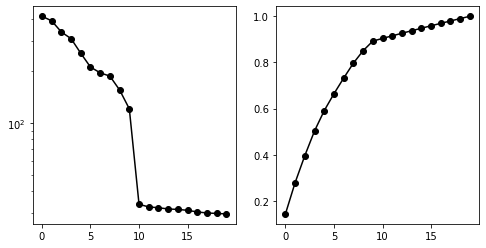

In [5]:
pca2 = PCA(n_components=20, svd_solver='randomized', whiten=True)
pca2.fit(X_train)
singular_values = pca2.singular_values_

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.semilogy(singular_values, '-o', color='k')

ax2 = fig.add_subplot(122)
ax2.plot(np.cumsum(singular_values)/np.sum(singular_values), '-o', color='k')

plt.show()

In [6]:
print(impute_type[3])
X_train, X_test, y_train, y_test = train_test_split(X_type[3], y, test_size=0.2, random_state=random_state)

model1 = RandomForestClassifier(random_state=random_state)
model1.fit(X_train, y_train)

acc_train = model1.score(X_train, y_train)
acc_test = model1.score(X_test, y_test)
print('trn: {:2.2%}'.format(acc_train))
print('tst: {:2.2%} \n'.format(acc_test))
    
# Select the 1st 10 principle components
pca = PCA(n_components=10, svd_solver='randomized', whiten=True)
pca.fit(X_train)

# We are training the model with only 10 features
X_train_pca = pca.transform(X_train)

model2 = RandomForestClassifier(random_state=random_state)
model2.fit(X_train_pca, y_train)

X_test_pca = pca.transform(X_test)

acc_train2 = model2.score(X_train_pca, y_train)
acc_test2 = model2.score(X_test_pca, y_test)
print('trn: {:2.2%}'.format(acc_train2))
print('tst: {:2.2%} \n'.format(acc_test2))
    
print('PCA was worse by: {:2.2%} \n'.format(acc_test2-acc_test))


probable
trn: 100.00%
tst: 70.00% 

trn: 100.00%
tst: 68.50% 

PCA was worse by: -1.50% 



Task 3
=====

Here I am performing 100 repeated hold-outs on each of the 4 required methods. This means I am splitting the data 100 times and recording the score each time in a matrix. I have decided to use this approach because my implementation of Pruned Decision Tree cannot utilize cross-validation. I have referenced the first example sent out in the recent announcement from Joerg to perform my 100 repeated hold-outs.  

The summary of the matrix created indicates that Random Forest > Pruned DT > DT > DS.  
In order to get the statistical significance on the above ranking, I ran the matrix through autorank and the results confirm that the differences of the means are statistically significant (p=0.000).  

I think the worst methods are performing so bad from the top two because they are overfitting and underfitting respectively (DTrees and DStumps).

For unpruned decision trees, because they are looking at all features, it is more likely to consider an unimportant feature, overfitting to the training set instead of correctly representing the overall dataset.
For decision stumps, because they are restricted to only looking at the best feature, it is more likely to become underfit as they are unable to consider more than 1 feature.

   Random Forest Pruned DT Regular DT Decision Stump
0          0.655      0.69       0.63           0.59
1          0.655     0.685      0.675          0.595
2           0.71     0.715       0.69          0.625
3          0.695      0.69       0.65          0.605
4           0.72     0.705       0.68           0.56
..           ...       ...        ...            ...
95          0.69     0.715      0.665           0.62
96         0.665      0.68      0.655           0.68
97         0.765     0.725       0.71           0.61
98         0.665     0.645       0.64          0.555
99          0.68     0.645       0.63           0.58

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count     100.000000  100.000000   100.00000      100.000000
mean        0.693950    0.690250     0.65505        0.603900
std         0.031561    0.028359     0.03291        0.029384
min         0.620000    0.625000     0.53500        0.535000
25%         0.675000    0.670000   

<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

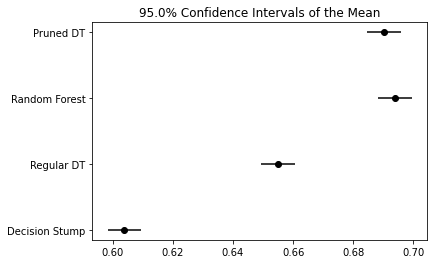

In [7]:
random_state = 567697779
np.random.seed(random_state)

newX = pca.transform(X_type[3])

clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=random_state)
#     X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)

Task 4
=====

We now perform the same experiment with 20% normal additive noise to the features. The order of classifiers remained the same.  

In order to check the statistical significance, we run the results through autorank again.  This time we are seeing no significance difference in RF and Pruned DT. The other classifiers remain statistically significant from eachother.  

The introduction of noise effecitively acts as a Regularization technique for our models, it makes the data harder to fit, and thereby making the models less overfit to the 10 best features and a closer fit to the actual data. From the result below we can gather that our stronger models Random Forest and Pruned DT are quite resistant to noise, as their performance were not affected by much. I believe the top two techniques are able to retain their positions because they both already incorporate some form of randomness when creating the model.

   Random Forest Pruned DT Regular DT Decision Stump
0           0.71     0.715      0.635           0.59
1           0.68      0.69       0.68          0.595
2            0.7      0.71      0.655          0.625
3            0.7      0.67       0.65          0.605
4          0.705       0.7      0.625           0.56
..           ...       ...        ...            ...
95         0.685       0.7      0.685          0.625
96          0.68     0.685      0.665          0.685
97         0.725     0.705      0.685           0.61
98         0.705     0.675       0.67          0.545
99         0.655      0.66       0.63           0.58

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count     100.000000  100.000000  100.000000       100.00000
mean        0.693200    0.687700    0.650150         0.60380
std         0.029289    0.025009    0.030809         0.02979
min         0.635000    0.620000    0.550000         0.53500
25%         0.670000    0.670000   

<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

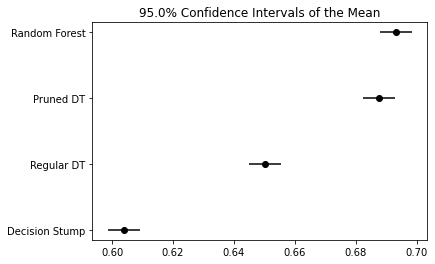

In [8]:
random_state = 567697779
np.random.seed(random_state)

random = np.random.default_rng()
noise = np.random.normal(0, 0.2, np.shape(newX))
X_noise4 = newX + np.multiply(noise, np.average(newX, axis=0))


# newX = pca.transform(X_type[3])

clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_noise4, y, test_size=0.2, random_state=random_state)
#     X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)

Task 5
=====

We now perform the same experiment with 20% normal multiplicative noise to the features. The order of classifiers remained the same.  

In order to check the statistical significance, we run the results through autorank again.  Once again we are seeing no significance difference in RF and Pruned DT. The other classifiers remain statistically significant from eachother.  

Once again the noise is achieving the same purpose, we are making all our models slightly less overfit. From the results observed below I do not believe there is a significant difference between 20% additive and 20% multiplicative noise. They both achieve simillar results. 

The main difference between additive noise and multiplicative noise is that the bigger values will be scaled harder in multiplicative, giving them more 'power' during the creation of the model. The fact that our results look very simillar to additive noise tells us that we don't have any features that affect the model greatly by itself - all our features have a simillar amount of influence.

   Random Forest Pruned DT Regular DT Decision Stump
0           0.75     0.705       0.69           0.57
1           0.69       0.7      0.615          0.585
2          0.715       0.7      0.665          0.615
3           0.67     0.705       0.64          0.605
4           0.67     0.705      0.675           0.56
..           ...       ...        ...            ...
95         0.725     0.695      0.675            0.6
96         0.665     0.675       0.61           0.63
97         0.755     0.705       0.66          0.605
98         0.715     0.675      0.615          0.555
99          0.66     0.635       0.61          0.575

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count      100.00000  100.000000  100.000000      100.000000
mean         0.69655    0.690900    0.654050        0.591250
std          0.02853    0.025059    0.033399        0.024867
min          0.64000    0.615000    0.560000        0.530000
25%          0.67500    0.675000   

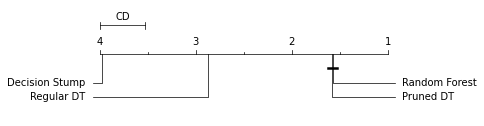

In [9]:
random_state = 567697779
np.random.seed(random_state)

# random = np.random.default_rng()
noise = np.random.normal(1, 0.2, np.shape(newX))
X_noise5 = np.multiply(newX,noise)


clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_noise5, y, test_size=0.2, random_state=random_state)
#     X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)

Task 6
=====

We now perform the same experiment with 5% class noise. This time between the top two, pruned Decision Tree came out on top, the order of the others remained the same. 

In order to check the statistical significance, we run the results through autorank again.  Once again we are seeing no significance difference in RF and Pruned DT. The other classifiers remain statistically significant from eachother.  

We are adding a slight noise to the class labels to closely resemble the real world. We know for a fact that the real-world data will always contain noise to some degree so adding a small amount of noise to our perfectly 50-50 distributed class labels can closer resemble real-life data.  

Once again we can observe our top models being quite resistant to noise, as they both remained close to eachother at around 66%, down 2% from the other noise generation methods. I think class noise negatively affected our results more because our class labels were very accurate to begin with, so instead of the noise reducing overfit as expected it actually provided the opposite effect.

   Random Forest Pruned DT Regular DT Decision Stump
0           0.63     0.635       0.53          0.555
1          0.675      0.71       0.65            0.6
2           0.71      0.71       0.66           0.61
3          0.665      0.68      0.645          0.595
4          0.665      0.72       0.69           0.61
..           ...       ...        ...            ...
95         0.675     0.655       0.62          0.655
96         0.665       0.7       0.64          0.605
97          0.67      0.68       0.67          0.595
98          0.68      0.68      0.675           0.58
99         0.685       0.7       0.64          0.645

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count     100.000000  100.000000  100.000000      100.000000
mean        0.670450    0.675750    0.630050        0.601800
std         0.030593    0.031337    0.036248        0.028977
min         0.575000    0.595000    0.530000        0.530000
25%         0.653750    0.650000   

<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

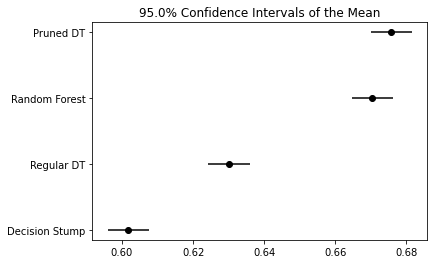

In [10]:
random_state = 567697779
np.random.seed(random_state)

flip = random.binomial(1, 0.05, y.shape).astype(bool)
y_flipped = np.where(flip, 1 - y, y)


clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(newX, y_flipped, test_size=0.2, random_state=random_state)
#     X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)

Task 7
=====

Finally, we perform the last test which is splitting the data and only adding 20% normal multiplicative noise to the training set, followed by the same noise to the test set. 

The two methods yield very simillar results.
When noise is added to the training set, the top two models lose their statistical significance.  
However when noise is added to the test dataset, all 4 models become statistically significant again.

Overall though, I think there is only a negligible difference between the two methods. This mostly indicates that the 10 features selected originally were very resistant to noise, and that Random Forest's performance will always be very simillar to Pruned DT for this specific set of data.

   Random Forest Pruned DT Regular DT Decision Stump
0           0.68     0.665       0.64           0.59
1           0.68      0.71      0.635          0.595
2           0.73     0.735       0.69          0.615
3          0.735     0.725      0.675           0.62
4          0.715       0.7      0.685           0.55
..           ...       ...        ...            ...
95          0.68     0.695       0.62          0.625
96         0.705      0.68       0.66           0.68
97          0.69     0.745       0.72           0.62
98         0.705      0.67      0.655          0.555
99          0.66      0.68       0.64           0.59

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count     100.000000  100.000000   100.00000      100.000000
mean        0.692900    0.687550     0.64520        0.604050
std         0.029993    0.027812     0.03163        0.026626
min         0.610000    0.610000     0.57500        0.535000
25%         0.675000    0.675000   

<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

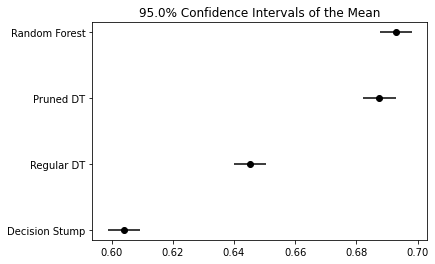

In [11]:
random_state = 567697779
np.random.seed(random_state)

clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=random_state)
    noise = np.random.normal(1, 0.2, np.shape(X_train))
    X_train = np.multiply(X_train,noise)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)

   Random Forest Pruned DT Regular DT Decision Stump
0          0.685      0.68      0.615          0.585
1           0.63     0.675      0.655          0.585
2            0.7      0.69      0.645           0.63
3           0.67     0.705      0.655          0.605
4          0.705     0.685       0.68          0.575
..           ...       ...        ...            ...
95         0.695     0.705      0.625          0.605
96         0.645      0.68       0.67           0.68
97          0.73       0.7      0.695          0.605
98          0.68      0.63      0.605           0.55
99         0.655     0.645       0.62          0.575

[100 rows x 4 columns]
       Random Forest   Pruned DT  Regular DT  Decision Stump
count     100.000000  100.000000  100.000000       100.00000
mean        0.688750    0.684400    0.644500         0.60280
std         0.031345    0.026849    0.033893         0.02963
min         0.625000    0.620000    0.530000         0.53500
25%         0.665000    0.670000   

<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

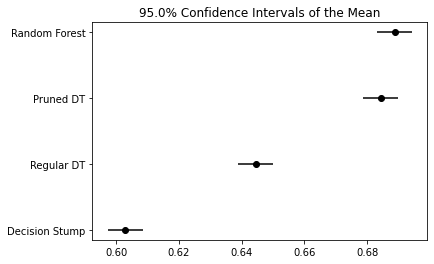

In [12]:
random_state = 567697779
np.random.seed(random_state)

clf_names = ["Random Forest", "Pruned DT", "Regular DT", "Decision Stump"]
results = pd.DataFrame(index = range(100), columns = clf_names)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=random_state)
    noise = np.random.normal(1, 0.2, np.shape(X_test))
    X_test = np.multiply(X_test,noise)
    
    RF  = RandomForestClassifier(n_estimators=10, random_state = random_state) #Random Forest
    DT  = DecisionTreeClassifier(random_state = random_state, criterion="entropy")#Regular DT
    
    prune = DT.cost_complexity_pruning_path(X_train, y_train) 
    acc = []
    for c in prune.ccp_alphas:
        acc.append(DecisionTreeClassifier(ccp_alpha=c, random_state = random_state, criterion="entropy").fit(X_train, y_train).score(X_test, y_test))#validation of pruning
    best_ccp_alpha = prune.ccp_alphas[np.argmax(acc)]
        
    PDT = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state = random_state, criterion="entropy")#Pruned DT
    DS  = DecisionTreeClassifier(max_depth=1,random_state = random_state) #Decision Stump

    results.at[i,"Random Forest"] =  RF.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Pruned DT"] =      PDT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Regular DT"] =     DT.fit(X_train, y_train).score(X_test, y_test)
    results.at[i,"Decision Stump"] = DS.fit(X_train, y_train).score(X_test, y_test)
    
    random_state = random_state + 50
    
print(results)
print(results.astype('float64').describe(include='all'))

res = autorank(results.astype('float64'), verbose=False)
print(res)
create_report(res)
plot_stats(res)